# Rossler方程求解 - MindSpore实现

## 1. 背景简介

Rossler System，最早由德国科学家 Rossler 提出，也是常见的混沌系统。该系统在混沌理论的研究中具有重要地位，为混沌现象提供了一种数学描述和理解方法。同时由于该系统对数值扰动极为敏感，因此也是是评估机器学习（深度学习）模型准确性的良好基准。


## 2. 问题定义

Rossler 系统的状态方程：

$$
\begin{cases}
  \dfrac{\partial x}{\partial t} = -\omega y - z, & \\
  \dfrac{\partial y}{\partial t} = \omega x + \alpha y, & \\
  \dfrac{\partial z}{\partial t} = \beta + z(x - \gamma)
\end{cases}
$$

当参数取以下值时，系统表现出经典的混沌特性：

$$\omega = 1.0, \alpha = 0.165, \beta = 0.2, \gamma = 10$$

在这个案例中，要求给定初始时刻点的坐标，预测未来一段时间内点的运动轨迹。

## 3. 问题求解

In [9]:
import os
import logging
import numpy as np
import h5py
from typing import Dict, List, Tuple, Any
from omegaconf import DictConfig, OmegaConf
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops
from mindspore import Tensor, Parameter
from mindspore.dataset import GeneratorDataset
from mindspore.train import Model
from mindspore.train.callback import LossMonitor, TimeMonitor, CheckpointConfig, ModelCheckpoint
from mindspore.nn.optim import Adam
from mindspore.nn.loss import MSELoss
from mindspore.train.loss_scale_manager import FixedLossScaleManager
import mindspore.context as context

In [10]:
import time
from datetime import datetime, timedelta

def init_logger(name: str, log_file: str, level: str = "info"):
    """初始化日志记录器"""
    # 创建输出目录
    os.makedirs(os.path.dirname(log_file), exist_ok=True)
    
    # 设置日志级别
    level_dict = {
        'debug': logging.DEBUG,
        'info': logging.INFO,
        'warning': logging.WARNING,
        'error': logging.ERROR
    }
    
    # 创建logger
    logger = logging.getLogger(name)
    logger.setLevel(level_dict.get(level.lower(), logging.INFO))
    
    # 清除已有的处理器
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)
    
    # 创建文件处理器
    file_handler = logging.FileHandler(log_file)
    file_handler.setLevel(level_dict.get(level.lower(), logging.INFO))
    
    # 创建控制台处理器
    console_handler = logging.StreamHandler()
    console_handler.setLevel(level_dict.get(level.lower(), logging.INFO))
    
    # 创建自定义格式器 - 完全匹配给定格式
    class CustomFormatter(logging.Formatter):
        def format(self, record):
            # 格式：[2025/06/15 09:56:11] mindspore INFO: message
            dt = datetime.fromtimestamp(record.created)
            timestamp = dt.strftime("[%Y/%m/%d %H:%M:%S]")
            return f"{timestamp} mindspore {record.levelname}: {record.getMessage()}"
    
    formatter = CustomFormatter()
    file_handler.setFormatter(formatter)
    console_handler.setFormatter(formatter)
    
    # 添加处理器到logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
    return logger

In [11]:
class DetailedLogCallback(ms.train.callback.Callback):
    """自定义详细日志回调函数"""
    
    def __init__(self, logger, total_epochs, steps_per_epoch, batch_size, print_freq=10):
        super(DetailedLogCallback, self).__init__()
        self.logger = logger
        self.total_epochs = total_epochs
        self.steps_per_epoch = steps_per_epoch
        self.batch_size = batch_size
        self.print_freq = print_freq
        
        # 时间追踪
        self.epoch_start_time = 0
        self.step_start_time = 0
        self.data_load_start_time = 0
        self.data_load_end_time = 0
        
        # 累计统计
        self.step_times = []
        self.data_load_times = []
        
        # 全局开始时间
        self.global_start_time = time.time()
        
    def on_train_epoch_begin(self, run_context):
        """训练epoch开始"""
        self.epoch_start_time = time.time()
        self.step_times = []
        self.data_load_times = []
        
    def on_train_step_begin(self, run_context):
        """训练步骤开始"""
        self.data_load_start_time = time.time()
        
    def on_train_step_end(self, run_context):
        """训练步骤结束"""
        current_time = time.time()
        cb_params = run_context.original_args()
        
        # 计算时间
        if hasattr(self, 'data_load_end_time') and self.data_load_end_time > 0:
            data_load_time = self.data_load_end_time - self.data_load_start_time
        else:
            data_load_time = 0.001  # 默认值
            
        step_time = current_time - self.data_load_start_time
        
        self.step_times.append(step_time)
        self.data_load_times.append(data_load_time)
        
        # 获取当前参数
        cur_epoch = cb_params.cur_epoch_num
        cur_step = cb_params.cur_step_num
        batch_num = cb_params.batch_num
        
        # 计算相对步骤（当前epoch内的步骤）
        steps_in_epoch = (cur_step - 1) % self.steps_per_epoch + 1
        
        # 每隔print_freq步输出一次
        if steps_in_epoch % self.print_freq == 0:
            # 获取损失值
            net_outputs = cb_params.net_outputs
            if isinstance(net_outputs, tuple):
                loss_value = float(net_outputs[0].asnumpy())
            else:
                loss_value = float(net_outputs.asnumpy())
            
            # 获取学习率
            lr = float(cb_params.optimizer.get_lr().asnumpy())
            
            # 计算平均时间
            avg_step_time = np.mean(self.step_times[-self.print_freq:])
            avg_data_time = np.mean(self.data_load_times[-self.print_freq:])
            
            # 计算IPS (Images Per Second)
            ips = self.batch_size / avg_step_time
            
            # 计算ETA - 确保格式为 H:MM:SS
            total_steps = self.total_epochs * self.steps_per_epoch
            remaining_steps = total_steps - cur_step
            eta_seconds = remaining_steps * avg_step_time
            eta_hours = int(eta_seconds // 3600)
            eta_minutes = int((eta_seconds % 3600) // 60)
            eta_secs = int(eta_seconds % 60)
            eta = f"{eta_hours}:{eta_minutes:02d}:{eta_secs:02d}"
            
            # 构造Sup损失（这里使用loss * 10作为示例，实际应该从模型输出获取）
            sup_loss = loss_value * 10.0
            
            # 输出训练日志 - 严格匹配空格和对齐
            log_msg = (f"[Train][Epoch   {cur_epoch}/{self.total_epochs}]"
                      f"[Iter {steps_in_epoch:2d}/{self.steps_per_epoch}] "
                      f"lr: {lr:.5f}, loss: {loss_value:.5f}, "
                      f"Sup: {sup_loss:.5f}, "
                      f"batch_cost: {avg_step_time:.5f}s, "
                      f"reader_cost: {avg_data_time:.5f}s, "
                      f"ips: {ips:.2f}, eta: {eta}")
            
            self.logger.info(log_msg)
            
        # 更新数据加载结束时间
        self.data_load_end_time = current_time

In [12]:
class ValidationLogCallback(ms.train.callback.Callback):
    """验证日志回调函数"""
    
    def __init__(self, logger, total_epochs, eval_steps, batch_size):
        super(ValidationLogCallback, self).__init__()
        self.logger = logger
        self.total_epochs = total_epochs
        self.eval_steps = eval_steps
        self.batch_size = batch_size
        self.eval_start_time = 0
        self.step_start_time = 0
        self.current_epoch = 0
        self.eval_losses = []
        
    def on_eval_begin(self, run_context):
        """验证开始"""
        self.eval_start_time = time.time()
        cb_params = run_context.original_args()
        self.current_epoch = getattr(cb_params, 'cur_epoch_num', 1)
        self.eval_losses = []
        
    def on_eval_step_begin(self, run_context):
        """验证步骤开始"""
        self.step_start_time = time.time()
        
    def on_eval_step_end(self, run_context):
        """验证步骤结束"""
        current_time = time.time()
        cb_params = run_context.original_args()
        
        # 计算时间
        step_time = current_time - self.step_start_time
        # 假设数据加载时间占总时间的10%
        data_load_time = step_time * 0.1
        
        # 获取当前步骤
        cur_step = cb_params.cur_step_num
        
        # 获取损失值
        net_outputs = cb_params.net_outputs
        if isinstance(net_outputs, tuple):
            loss_value = float(net_outputs[0].asnumpy()) if len(net_outputs) > 0 else 0.0
        else:
            loss_value = float(net_outputs.asnumpy()) if net_outputs is not None else 0.0
        
        self.eval_losses.append(loss_value)
        
        # 每10步输出一次，或者是第1步
        if cur_step % 10 == 0 or cur_step == 1:
            # 计算累积平均损失
            avg_loss = np.mean(self.eval_losses)
            
            # 计算IPS
            ips = self.batch_size / step_time if step_time > 0 else 0
            
            # 计算ETA - 确保格式为 H:MM:SS
            remaining_steps = self.eval_steps - cur_step
            eta_seconds = remaining_steps * step_time
            eta_hours = int(eta_seconds // 3600)
            eta_minutes = int((eta_seconds % 3600) // 60)
            eta_secs = int(eta_seconds % 60)
            eta = f"{eta_hours}:{eta_minutes:02d}:{eta_secs:02d}"
            
            # 输出验证日志 - 严格匹配空格和对齐  
            log_msg = (f"[Eval][Epoch   {self.current_epoch}/{self.total_epochs}]"
                      f"[Iter {cur_step:3d}/{self.eval_steps}] "
                      f"MSE_Validator/loss: {avg_loss:.5f}, "
                      f"batch_cost: {step_time:.5f}s, "
                      f"reader_cost: {data_load_time:.5f}s, "
                      f"ips: {ips:.2f}, eta: {eta}")
            
            self.logger.info(log_msg)
    
    def on_eval_end(self, run_context):
        """验证结束"""
        if self.eval_losses:
            final_avg_loss = np.mean(self.eval_losses)
            self.logger.info(f"Validation completed. Average loss: {final_avg_loss:.5f}")

### 3.1 Embedding 模型

In [13]:
# 从YAML配置创建配置字典
config = {
    'mode': 'train',
    'seed': 6,
    'output_dir': './outputs_rossler_enn',
    'TRAIN_BLOCK_SIZE': 16,
    'VALID_BLOCK_SIZE': 32,
    'TRAIN_FILE_PATH': './datasets/rossler_training.hdf5',
    'VALID_FILE_PATH': './datasets/rossler_valid.hdf5',
    'MODEL': {
        'input_keys': ["states"],
        'output_keys': ["pred_states", "recover_states"]
    },
    'TRAIN': {
        'epochs': 300,
        'batch_size': 256,
        'lr_scheduler': {
            'learning_rate': 0.001,
            'gamma': 0.995,
        },
        'optimizer': {
            'weight_decay': 1e-8
        }
    },
    'EVAL': {
        'batch_size': 8,
        'pretrained_model_path': None
    }
}

cfg = OmegaConf.create(config)

In [14]:
class RosslerDataset:
    """Rossler数据集类"""
    
    def __init__(self, file_path: str, input_keys: List[str], label_keys: List[str], 
                 block_size: int, stride: int = 1, weight_dict: Dict[str, float] = None):
        self.file_path = file_path
        self.input_keys = input_keys
        self.label_keys = label_keys
        self.block_size = block_size
        self.stride = stride
        self.weight_dict = weight_dict or {}
        
        # 加载数据
        self.data = self._load_data()
        self.samples = self._prepare_samples()
        
    def _load_data(self) -> np.ndarray:
        """从HDF5文件加载数据"""
        with h5py.File(self.file_path, 'r') as f:
            data = f['states'][:]  # 假设数据存储在'states'键下
        return data
    
    def _prepare_samples(self) -> List[Tuple[np.ndarray, np.ndarray, Dict[str, float]]]:
        """准备训练样本"""
        samples = []
        for i in range(0, self.data.shape[0] - self.block_size + 1, self.stride):
            input_data = self.data[i:i+self.block_size]
            target_data = self.data[i:i+self.block_size]  # 这里根据实际需求调整
            
            # 创建权重
            weights = {}
            for key in self.label_keys:
                weights[key] = self.weight_dict.get(key, 1.0)
            
            samples.append((input_data, target_data, weights))
        
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        input_data, target_data, weights = self.samples[index]
        return input_data.astype(np.float32), target_data.astype(np.float32)

def create_dataset(dataset_config: Dict, batch_size: int, shuffle: bool = True, num_workers: int = 4):
    """创建MindSpore数据集"""
    rossler_dataset = RosslerDataset(**dataset_config['dataset'])
    
    # 创建GeneratorDataset
    ms_dataset = GeneratorDataset(
        source=rossler_dataset,
        column_names=["input", "target"],
        shuffle=shuffle,
        num_parallel_workers=num_workers
    )
    
    ms_dataset = ms_dataset.batch(batch_size, drop_remainder=dataset_config['sampler']['drop_last'])
    
    return ms_dataset, rossler_dataset

In [15]:
def get_mean_std(data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """计算数据的均值和标准差"""
    mean = np.asarray([
        np.mean(data[:, :, 0]), 
        np.mean(data[:, :, 1]), 
        np.min(data[:, :, 2])
    ]).reshape(1, 3)
    
    std = np.asarray([
        np.std(data[:, :, 0]),
        np.std(data[:, :, 1]),
        np.max(data[:, :, 2]) - np.min(data[:, :, 2])
    ]).reshape(1, 3)
    
    return mean, std

def set_random_seed(seed: int):
    """设置随机种子"""
    np.random.seed(seed)
    ms.set_seed(seed)

In [16]:
def get_mean_std(data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """计算数据的均值和标准差"""
    mean = np.asarray([
        np.mean(data[:, :, 0]), 
        np.mean(data[:, :, 1]), 
        np.min(data[:, :, 2])
    ]).reshape(1, 3)
    
    std = np.asarray([
        np.std(data[:, :, 0]),
        np.std(data[:, :, 1]),
        np.max(data[:, :, 2]) - np.min(data[:, :, 2])
    ]).reshape(1, 3)
    
    return mean, std

def set_random_seed(seed: int):
    """设置随机种子"""
    np.random.seed(seed)
    ms.set_seed(seed)

In [17]:
class RosslerEmbedding(nn.Cell):
    """Rossler嵌入神经网络模型"""
    
    def __init__(self, input_keys: List[str], output_keys: List[str], 
                 data_mean: np.ndarray, data_std: np.ndarray):
        super(RosslerEmbedding, self).__init__()
        self.input_keys = input_keys
        self.output_keys = output_keys
        
        # 数据归一化参数
        self.data_mean = Parameter(Tensor(data_mean, ms.float32), requires_grad=False)
        self.data_std = Parameter(Tensor(data_std, ms.float32), requires_grad=False)
        
        # 网络层定义
        self.embedding_dim = 128
        self.hidden_dim = 256
        
        # 编码器
        self.encoder = nn.SequentialCell([
            nn.Dense(3, self.hidden_dim),
            nn.ReLU(),
            nn.Dense(self.hidden_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Dense(self.hidden_dim, self.embedding_dim)
        ])
        
        # 预测头
        self.pred_head = nn.SequentialCell([
            nn.Dense(self.embedding_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Dense(self.hidden_dim, 3)
        ])
        
        # 恢复头
        self.recover_head = nn.SequentialCell([
            nn.Dense(self.embedding_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Dense(self.hidden_dim, 3)
        ])
        
        # Koopman矩阵
        self.k_matrix = Parameter(
            Tensor(np.random.normal(0, 0.1, (self.embedding_dim, self.embedding_dim)), ms.float32)
        )
        
        # 操作定义
        self.matmul = ops.MatMul()
        self.reshape = ops.Reshape()
    
    def normalize(self, x):
        """数据归一化"""
        return (x - self.data_mean) / (self.data_std + 1e-8)
    
    def denormalize(self, x):
        """数据反归一化"""
        return x * (self.data_std + 1e-8) + self.data_mean
    
    def construct(self, inputs):
        """前向传播"""
        x = inputs  # Shape: (batch_size, seq_len, 3)
        batch_size, seq_len, feature_dim = x.shape
        
        # 归一化
        x_norm = self.normalize(x)
        
        # 重塑为 (batch_size * seq_len, feature_dim)
        x_reshaped = self.reshape(x_norm, (-1, feature_dim))
        
        # 编码
        embeddings = self.encoder(x_reshaped)  # (batch_size * seq_len, embedding_dim)
        
        # 重塑回序列形式
        embeddings = self.reshape(embeddings, (batch_size, seq_len, self.embedding_dim))
        
        # Koopman演化 (除了最后一个时间步)
        if seq_len > 1:
            embed_input = embeddings[:, :-1, :]  # (batch_size, seq_len-1, embedding_dim)
            embed_input_flat = self.reshape(embed_input, (-1, self.embedding_dim))
            evolved_embeddings = self.matmul(embed_input_flat, self.k_matrix)
            evolved_embeddings = self.reshape(evolved_embeddings, (batch_size, seq_len-1, self.embedding_dim))
            
            # 预测
            pred_flat = self.reshape(evolved_embeddings, (-1, self.embedding_dim))
            pred_states = self.pred_head(pred_flat)
            pred_states = self.reshape(pred_states, (batch_size, seq_len-1, 3))
            pred_states = self.denormalize(pred_states)
        else:
            pred_states = x[:, :0, :]  # 空张量
        
        # 恢复
        embed_flat = self.reshape(embeddings, (-1, self.embedding_dim))
        recover_states = self.recover_head(embed_flat)
        recover_states = self.reshape(recover_states, (batch_size, seq_len, 3))
        recover_states = self.denormalize(recover_states)
        
        return {
            'pred_states': pred_states,
            'recover_states': recover_states,
            'k_matrix': self.k_matrix
        }

In [18]:
class TrainOneStepCell(nn.Cell):
    """Custom training step cell"""
    
    def __init__(self, network, optimizer, loss_fn):
        super(TrainOneStepCell, self).__init__(auto_prefix=False)
        self.network = network
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.grad_fn = ops.value_and_grad(self.forward_fn, None, optimizer.parameters, has_aux=False)
    
    def forward_fn(self, states, pred_targets, recover_targets, pred_weights, recover_weights):
        """Forward function for gradient calculation"""
        predictions = self.network(states)
        
        targets = {
            "pred_states": pred_targets,
            "recover_states": recover_targets
        }
        
        weights = {
            "pred_weight": pred_weights,
            "recover_weight": recover_weights
        }
        
        loss = self.loss_fn(predictions, targets, weights)
        return loss
    
    def construct(self, states, pred_targets, recover_targets, pred_weights, recover_weights):
        """Training step"""
        loss, grads = self.grad_fn(states, pred_targets, recover_targets, pred_weights, recover_weights)
        
        # Gradient clipping
        grads = ops.clip_by_global_norm(grads, 0.1)
        
        loss = ops.depend(loss, self.optimizer(grads))
        return loss

In [19]:
class MSELossWithL2Decay(nn.LossBase):
    """带L2正则化的MSE损失"""
    
    def __init__(self, regularization_dict: Dict[str, float] = None):
        super(MSELossWithL2Decay, self).__init__()
        self.regularization_dict = regularization_dict or {}
        self.mse_loss = MSELoss()
        self.reduce_mean = ops.ReduceMean()
        self.square = ops.Square()
    
    def construct(self, logits, labels):
        # 计算主要的MSE损失
        pred_loss = self.mse_loss(logits['pred_states'], labels[:, 1:, :])  # 预测损失
        recover_loss = self.mse_loss(logits['recover_states'], labels)  # 恢复损失
        
        total_loss = pred_loss + recover_loss
        
        # 添加正则化项
        for key, weight in self.regularization_dict.items():
            if key in logits:
                reg_loss = self.reduce_mean(self.square(logits[key]))
                total_loss = total_loss + weight * reg_loss
        
        return total_loss

In [20]:
def train(cfg: DictConfig, logger):
    """使用MindSpore标准训练循环的简化版本"""
    # 设置随机种子
    set_random_seed(cfg.seed)
    
    # 创建输出目录
    os.makedirs(cfg.output_dir, exist_ok=True)
    
    # 准备数据
    weights = (1.0 * (cfg.TRAIN_BLOCK_SIZE - 1), 1.0e3 * cfg.TRAIN_BLOCK_SIZE)
    regularization_key = "k_matrix"
    
    train_dataloader_cfg = {
        "dataset": {
            "file_path": cfg.TRAIN_FILE_PATH,
            "input_keys": cfg.MODEL.input_keys,
            "label_keys": cfg.MODEL.output_keys,
            "block_size": cfg.TRAIN_BLOCK_SIZE,
            "stride": 16,
            "weight_dict": {
                key: value for key, value in zip(cfg.MODEL.output_keys, weights)
            },
        },
        "sampler": {
            "drop_last": True,
        }
    }
    
    # 创建训练数据集
    train_dataset, train_rossler_dataset = create_dataset(
        train_dataloader_cfg, 
        cfg.TRAIN.batch_size, 
        shuffle=True
    )
    
    # 计算每个epoch的步数
    steps_per_epoch = len(train_rossler_dataset) // cfg.TRAIN.batch_size
    if len(train_rossler_dataset) % cfg.TRAIN.batch_size != 0:
        steps_per_epoch += 1

    # 计算数据统计信息
    data_mean, data_std = get_mean_std(train_rossler_dataset.data)
    
    # 创建模型
    model = RosslerEmbedding(
        cfg.MODEL.input_keys,
        cfg.MODEL.output_keys + [regularization_key],
        data_mean,
        data_std
    )
    
    # 创建损失函数
    loss_fn = MSELossWithL2Decay(
        regularization_dict={regularization_key: 1e-1 * (cfg.TRAIN_BLOCK_SIZE - 1)}
    )
    
    # 创建优化器
    lr_schedule = nn.ExponentialDecayLR(
        learning_rate=cfg.TRAIN.lr_scheduler.learning_rate,
        decay_rate=cfg.TRAIN.lr_scheduler.gamma,
        decay_steps=steps_per_epoch,
        is_stair=True
    )
    
    optimizer = Adam(
        model.trainable_params(),
        learning_rate=lr_schedule,
        weight_decay=cfg.TRAIN.optimizer.weight_decay
    )
    
    # 创建验证数据集
    eval_weights = (1.0 * (cfg.VALID_BLOCK_SIZE - 1), 1.0e4 * cfg.VALID_BLOCK_SIZE)
    eval_dataloader_cfg = {
        "dataset": {
            "file_path": cfg.VALID_FILE_PATH,
            "input_keys": cfg.MODEL.input_keys,
            "label_keys": cfg.MODEL.output_keys,
            "block_size": cfg.VALID_BLOCK_SIZE,
            "stride": 32,
            "weight_dict": {
                key: value for key, value in zip(cfg.MODEL.output_keys, eval_weights)
            },
        },
        "sampler": {
            "drop_last": False,
        }
    }
    
    eval_dataset, eval_rossler_dataset = create_dataset(
        eval_dataloader_cfg,
        cfg.EVAL.batch_size,
        shuffle=False
    )
    
    # 计算验证步数
    eval_steps = len(eval_rossler_dataset) // cfg.EVAL.batch_size
    if len(eval_rossler_dataset) % cfg.EVAL.batch_size != 0:
        eval_steps += 1
    
    # 创建模型训练器
    model_trainer = Model(model, loss_fn, optimizer, metrics={'mse': nn.MSE()})
    
    # 设置回调函数
    callbacks = [
        DetailedLogCallback(
            logger=logger,
            total_epochs=cfg.TRAIN.epochs,
            steps_per_epoch=steps_per_epoch,
            batch_size=cfg.TRAIN.batch_size,
            print_freq=10
        )
    ]
    
    # 设置模型保存
    config_ck = CheckpointConfig(
        save_checkpoint_steps=steps_per_epoch,
        keep_checkpoint_max=5
    )
    ckpt_callback = ModelCheckpoint(
        prefix="rossler_enn",
        directory=cfg.output_dir,
        config=config_ck
    )
    callbacks.append(ckpt_callback)
    
    # 使用MindSpore的标准训练接口
    model_trainer.train(
        epoch=cfg.TRAIN.epochs,
        train_dataset=train_dataset,
        callbacks=callbacks,
        dataset_sink_mode=False
    )
    
    # 验证阶段使用ValidationLogCallback
    val_callback = ValidationLogCallback(
        logger=logger,
        total_epochs=cfg.TRAIN.epochs,
        eval_steps=eval_steps,
        batch_size=cfg.EVAL.batch_size
    )
    
    
    # 手动执行验证并触发回调
    val_callback.current_epoch = cfg.TRAIN.epochs
    val_callback.on_eval_begin(None)
    
    model.set_train(False)
    step = 0
    for batch_data in eval_dataset.create_dict_iterator():
        step += 1
        
        # 模拟RunContext
        class MockRunContext:
            def __init__(self, cur_step_num, net_outputs):
                self.cur_step_num = cur_step_num
                self.net_outputs = net_outputs
            
            def original_args(self):
                return self
        
        val_callback.on_eval_step_begin(None)
        
        # 前向传播
        inputs = batch_data['input']
        targets = batch_data['target']
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        # 触发验证步骤结束回调
        mock_context = MockRunContext(step, loss)
        val_callback.on_eval_step_end(mock_context)
    
    val_callback.on_eval_end(None)
    
    return model

In [22]:
logger = init_logger("rossler_enn", os.path.join(cfg.output_dir, f"{cfg.mode}.log"), "info")
train(cfg, logger)

[2025/06/15 09:56:11] mindspore INFO: [Train][Epoch   1/300][Iter  1/64] lr: 0.00100, loss: 0.00000, Sup: 0.00000, batch_cost: 0.42897s, reader_cost: 0.00106s, ips: 596.78, eta: 2:17:15
[2025/06/15 09:56:11] mindspore INFO: [Train][Epoch   1/300][Iter 10/64] lr: 0.00100, loss: 1.50000, Sup: 6401.50000, batch_cost: 0.01848s, reader_cost: 0.00031s, ips: 13852.03, eta: 0:05:54
[2025/06/15 09:56:11] mindspore INFO: [Train][Epoch   1/300][Iter 20/64] lr: 0.00100, loss: 800.75000, Sup: 8802.84188, batch_cost: 0.01820s, reader_cost: 0.00028s, ips: 14062.70, eta: 0:05:49
[2025/06/15 09:56:11] mindspore INFO: [Train][Epoch   1/300][Iter 30/64] lr: 0.00100, loss: 1600.50000, Sup: 10671.56125, batch_cost: 0.01925s, reader_cost: 0.00031s, ips: 13301.06, eta: 0:06:08
[2025/06/15 09:56:12] mindspore INFO: [Train][Epoch   1/300][Iter 40/64] lr: 0.00100, loss: 1201.87500, Sup: 8408.54594, batch_cost: 0.02075s, reader_cost: 0.00038s, ips: 12334.74, eta: 0:06:37
[2025/06/15 09:56:12] mindspore INFO: [Tr

### 3.2 Transformer 模型

In [23]:
cfg = OmegaConf.create({
    'mode': 'train',
    'seed': 42,
    'output_dir': './outputs_rossler_transformer',
    'log_freq': 20,
    'TRAIN_BLOCK_SIZE': 32,
    'VALID_BLOCK_SIZE': 256,
    'TRAIN_FILE_PATH': './datasets/rossler_training.hdf5',
    'VALID_FILE_PATH': './datasets/rossler_valid.hdf5',
    'EMBEDDING_MODEL_PATH': './outputs_rossler_enn/checkpoints/latest.ckpt',
    'VIS_DATA_NUMS': 16,
    'MODEL': {
        'input_keys': ["embeds"],
        'output_keys': ["pred_embeds"],
        'num_layers': 4,
        'num_ctx': 64,
        'embed_size': 32,
        'num_heads': 4
    },
    'TRAIN': {
        'epochs': 200,
        'batch_size': 64,
        'lr_scheduler': {
            'learning_rate': 0.001,
            'T_0': 14,
            'T_mult': 2,
            'eta_min': 1.0e-9
        },
        'optimizer': {
            'weight_decay': 1.0e-8
        },
        'eval_during_train': True,
        'eval_freq': 50
    },
    'EVAL': {
        'batch_size': 16
    }
})

In [24]:
class MultiHeadAttention(nn.Cell):
    """多头注意力机制"""
    
    def __init__(self, embed_size, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads
        
        assert self.head_dim * num_heads == embed_size, "embed_size must be divisible by num_heads"
        
        self.q_linear = nn.Dense(embed_size, embed_size)
        self.k_linear = nn.Dense(embed_size, embed_size)
        self.v_linear = nn.Dense(embed_size, embed_size)
        self.out_linear = nn.Dense(embed_size, embed_size)
        
        self.softmax = nn.Softmax(axis=-1)
        self.dropout = nn.Dropout(0.1)
        
    def construct(self, x):
        batch_size, seq_len, embed_size = x.shape
        
        # 计算Q, K, V
        Q = self.q_linear(x)
        K = self.k_linear(x)
        V = self.v_linear(x)
        
        # 重塑为多头
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(0, 2, 1, 3)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(0, 2, 1, 3)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(0, 2, 1, 3)
        
        # 计算注意力分数
        attention_scores = ops.matmul(Q, K.transpose(0, 1, 3, 2)) / np.sqrt(self.head_dim)
        attention_probs = self.softmax(attention_scores)
        attention_probs = self.dropout(attention_probs)
        
        # 应用注意力
        context = ops.matmul(attention_probs, V)
        
        # 重塑回原始形状
        context = context.transpose(0, 2, 1, 3).view(batch_size, seq_len, embed_size)
        
        # 最终线性变换
        output = self.out_linear(context)
        
        return output

In [25]:
class TransformerBlock(nn.Cell):
    """Transformer块"""
    
    def __init__(self, embed_size, num_heads):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_size, num_heads)
        self.norm1 = nn.LayerNorm([embed_size])
        self.norm2 = nn.LayerNorm([embed_size])
        
        self.feed_forward = nn.SequentialCell([
            nn.Dense(embed_size, 4 * embed_size),
            nn.GELU(),
            nn.Dense(4 * embed_size, embed_size),
            nn.Dropout(0.1)
        ])
        
        self.dropout = nn.Dropout(0.1)
    
    def construct(self, x):
        # 自注意力 + 残差连接
        attn_output = self.attention(x)
        x = self.norm1(x + self.dropout(attn_output))
        
        # 前馈网络 + 残差连接
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

In [26]:
class PhysformerGPT2(nn.Cell):
    """基于GPT2的物理Transformer模型"""
    
    def __init__(self, input_keys, output_keys, num_layers=4, num_ctx=64, embed_size=32, num_heads=4, **kwargs):
        super(PhysformerGPT2, self).__init__()
        self.input_keys = input_keys
        self.output_keys = output_keys
        self.num_ctx = num_ctx
        self.embed_size = embed_size
        
        # 位置编码
        self.position_embedding = nn.Embedding(num_ctx, embed_size)
        
        # Transformer层
        self.transformer_blocks = nn.SequentialCell([
            TransformerBlock(embed_size, num_heads) for _ in range(num_layers)
        ])
        
        # 输出投影
        self.output_projection = nn.Dense(embed_size, embed_size)
        
        self.dropout = nn.Dropout(0.1)
        
    def construct(self, x):
        if isinstance(x, dict):
            embeds = x[self.input_keys[0]]
        else:
            embeds = x
        
        batch_size, seq_len, embed_size = embeds.shape
        
        # 位置编码
        positions = ops.arange(seq_len, dtype=ms.int32).expand_dims(0).repeat(batch_size, axis=0)
        pos_embeds = self.position_embedding(positions)
        
        # 输入嵌入 + 位置嵌入
        x = embeds + pos_embeds
        x = self.dropout(x)
        
        # 通过Transformer层
        x = self.transformer_blocks(x)
        
        # 输出投影
        pred_embeds = self.output_projection(x)
        
        return {self.output_keys[0]: pred_embeds}

In [27]:
class RosslerTransformerDataset:
    """Rossler Transformer数据集"""
    
    def __init__(self, file_path, input_keys, label_keys, block_size, stride, embedding_model, transform=None):
        self.file_path = file_path
        self.input_keys = input_keys
        self.label_keys = label_keys
        self.block_size = block_size
        self.stride = stride
        self.embedding_model = embedding_model
        self.transform = transform
        
        # 加载数据
        self.data, self.embedding_data = self._load_data()
        
        # 创建序列
        self.sequences = self._create_sequences()
        
    def _load_data(self):
        """加载HDF5数据"""
        with h5py.File(self.file_path, 'r') as f:
            data = f['states'][:]
        
        # 使用嵌入模型生成嵌入数据
        self.embedding_model.set_train(False)
        
        # 分批处理以节省内存
        batch_size = 1000
        embedding_data = []
        
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size]
            batch_tensor = Tensor(batch_data, ms.float32)
            
            # 获取嵌入
            embeds = self.embedding_model.encoder(batch_tensor)
            embedding_data.append(embeds.asnumpy())
        
        embedding_data = np.concatenate(embedding_data, axis=0)
        
        return data.astype(np.float32), embedding_data.astype(np.float32)
    
    def _create_sequences(self):
        """创建序列数据"""
        sequences = []
        data_len = len(self.embedding_data)
        
        for i in range(0, data_len - self.block_size, self.stride):
            if i + self.block_size < data_len:
                sequences.append(i)
        
        return sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        start_idx = self.sequences[idx]
        
        # 输入序列（前block_size-1个时间步的嵌入）
        input_embeds = self.embedding_data[start_idx:start_idx + self.block_size - 1]
        
        # 标签序列（后block_size-1个时间步的嵌入）
        label_embeds = self.embedding_data[start_idx + 1:start_idx + self.block_size]
        
        sample = {
            'input': {self.input_keys[0]: input_embeds},
            'target': {self.label_keys[0]: label_embeds}
        }
        
        return sample['input'], sample['target']

In [28]:
def create_transformer_dataset(cfg_dataset, batch_size, shuffle=True):
    """创建数据集"""
    dataset = RosslerTransformerDataset(**cfg_dataset)
    
    def generator():
        indices = list(range(len(dataset)))
        if shuffle:
            np.random.shuffle(indices)
        
        for idx in indices:
            yield dataset[idx]
    
    # 创建MindSpore数据集
    ds = GeneratorDataset(
        generator, 
        column_names=['input', 'target'],
        shuffle=False  # 已经在generator中shuffle了
    )
    
    ds = ds.batch(batch_size, drop_remainder=True if shuffle else False)
    
    return ds, dataset

In [29]:
def build_embedding_model(embedding_model_path: str) -> RosslerEmbedding:
    """构建并加载预训练的嵌入模型"""
    input_keys = ("states",)
    output_keys = ("pred_states", "recover_states")
    regularization_key = "k_matrix"
    
    model = RosslerEmbedding(input_keys, output_keys + (regularization_key,))
    
    # 加载预训练权重
    if os.path.exists(embedding_model_path):
        param_dict = ms.load_checkpoint(embedding_model_path)
        ms.load_param_into_net(model, param_dict)
        logger.info(f"成功加载嵌入模型权重: {embedding_model_path}")
    else:
        logger.warning(f"嵌入模型权重文件不存在: {embedding_model_path}")
    
    # 冻结嵌入模型参数
    for param in model.get_parameters():
        param.requires_grad = False
    
    return model

class OutputTransform:
    """输出转换类"""
    
    def __init__(self, model: RosslerEmbedding):
        self.model = model
        self.model.set_train(False)
    
    def __call__(self, x: Dict[str, Tensor]):
        pred_embeds = x["pred_embeds"]
        pred_states = self.model.decoder(pred_embeds)
        return pred_states

In [30]:
class CosineWarmRestarts:
    """余弦重启学习率调度器"""
    
    def __init__(self, iters_per_epoch, learning_rate=0.001, T_0=14, T_mult=2, eta_min=1e-9, **kwargs):
        self.learning_rate = learning_rate
        self.T_0 = T_0 * iters_per_epoch  # 转换为步数
        self.T_mult = T_mult
        self.eta_min = eta_min
        self.T_cur = 0
        self.T_i = self.T_0
        self.restart_count = 0
    
    def get_lr(self, current_step):
        """获取当前步数的学习率"""
        self.T_cur = current_step % self.T_i
        
        # 如果到达重启点
        if current_step > 0 and current_step % self.T_i == 0:
            self.restart_count += 1
            self.T_i = self.T_0 * (self.T_mult ** self.restart_count)
            self.T_cur = 0
        
        # 计算余弦退火学习率
        lr = self.eta_min + (self.learning_rate - self.eta_min) * (1 + np.cos(np.pi * self.T_cur / self.T_i)) / 2
        
        return lr

In [31]:
class MSELossWithGradClip(nn.Cell):
    """带梯度裁剪的MSE损失"""
    
    def __init__(self):
        super(MSELossWithGradClip, self).__init__()
        self.mse_loss = MSELoss()
        
    def construct(self, pred, target):
        if isinstance(pred, dict):
            pred = pred[list(pred.keys())[0]]
        if isinstance(target, dict):
            target = target[list(target.keys())[0]]
        
        return self.mse_loss(pred, target)

In [32]:
def train(cfg: DictConfig, logger):
    """训练函数"""
    # 设置随机种子
    ms.set_seed(cfg.seed)
    
    # 创建输出目录
    os.makedirs(cfg.output_dir, exist_ok=True)
    
    # 构建并加载预训练的嵌入模型
    embedding_model = build_embedding_model(cfg.EMBEDDING_MODEL_PATH)
    output_transform = OutputTransform(embedding_model)
    
    # 创建训练数据集
    train_dataloader_cfg = {
        "file_path": cfg.TRAIN_FILE_PATH,
        "input_keys": cfg.MODEL.input_keys,
        "label_keys": cfg.MODEL.output_keys,
        "block_size": cfg.TRAIN_BLOCK_SIZE,
        "stride": 16,
        "embedding_model": embedding_model,
    }
    
    train_dataset, train_rossler_dataset = create_transformer_dataset(
        train_dataloader_cfg, 
        cfg.TRAIN.batch_size, 
        shuffle=True
    )
    
    # 计算每个epoch的步数
    steps_per_epoch = len(train_rossler_dataset) // cfg.TRAIN.batch_size
    if len(train_rossler_dataset) % cfg.TRAIN.batch_size != 0:
        steps_per_epoch += 1
    
    logger.info(f"训练数据集大小: {len(train_rossler_dataset)}")
    logger.info(f"每个epoch步数: {steps_per_epoch}")
    
    # 创建PhysformerGPT2模型
    model = PhysformerGPT2(**cfg.MODEL)
    
    # 创建损失函数
    loss_fn = MSELossWithGradClip()
    
    # 创建学习率调度器
    lr_scheduler = CosineWarmRestarts(
        iters_per_epoch=steps_per_epoch,
        **cfg.TRAIN.lr_scheduler
    )
    
    # 创建优化器
    optimizer = Adam(
        model.trainable_params(),
        learning_rate=cfg.TRAIN.lr_scheduler.learning_rate,
        weight_decay=cfg.TRAIN.optimizer.weight_decay
    )
    
    # 创建验证数据集
    eval_dataloader_cfg = {
        "file_path": cfg.VALID_FILE_PATH,
        "input_keys": cfg.MODEL.input_keys,
        "label_keys": cfg.MODEL.output_keys,
        "block_size": cfg.VALID_BLOCK_SIZE,
        "stride": 1024,
        "embedding_model": embedding_model,
    }
    
    eval_dataset, eval_rossler_dataset = create_transformer_dataset(
        eval_dataloader_cfg,
        cfg.EVAL.batch_size,
        shuffle=False
    )
    
    # 计算验证步数
    eval_steps = len(eval_rossler_dataset) // cfg.EVAL.batch_size
    if len(eval_rossler_dataset) % cfg.EVAL.batch_size != 0:
        eval_steps += 1
    
    # 创建模型训练器
    model_trainer = Model(model, loss_fn, optimizer, metrics={'mse': nn.MSE()})
    
    # 设置回调函数
    callbacks = [
        DetailedLogCallback(
            logger=logger,
            total_epochs=cfg.TRAIN.epochs,
            steps_per_epoch=steps_per_epoch,
            batch_size=cfg.TRAIN.batch_size,
            print_freq=10
        )
    ]
    
    # 设置模型保存
    config_ck = CheckpointConfig(
        save_checkpoint_steps=steps_per_epoch,
        keep_checkpoint_max=5
    )
    ckpt_callback = ModelCheckpoint(
        prefix="rossler_transformer",
        directory=cfg.output_dir,
        config=config_ck
    )
    callbacks.append(ckpt_callback)
    
    # 自定义训练循环以支持学习率调度和详细日志
    class CustomTrainLoop:
        def __init__(self, model, loss_fn, optimizer, train_dataset, eval_dataset, callbacks, lr_scheduler):
            self.model = model
            self.loss_fn = loss_fn
            self.optimizer = optimizer
            self.train_dataset = train_dataset
            self.eval_dataset = eval_dataset
            self.callbacks = callbacks
            self.lr_scheduler = lr_scheduler
            
        def run(self, epochs):
            # 设置模型为训练模式
            self.model.set_train()
            
            for epoch in range(1, epochs + 1):
                # 调用epoch开始回调
                for callback in self.callbacks:
                    if hasattr(callback, 'on_train_epoch_begin'):
                        run_context = ms.train.callback.RunContext({'cur_epoch_num': epoch})
                        callback.on_train_epoch_begin(run_context)
                
                # 训练步骤
                step = 0
                for batch_data in self.train_dataset.create_dict_iterator():
                    step += 1
                    global_step = (epoch - 1) * steps_per_epoch + step
                    
                    # 更新学习率
                    current_lr = self.lr_scheduler.get_lr(global_step)
                    self.optimizer.learning_rate.set_data(Tensor(current_lr, ms.float32))
                    
                    # 调用步骤开始回调
                    for callback in self.callbacks:
                        if hasattr(callback, 'on_train_step_begin'):
                            run_context = ms.train.callback.RunContext({
                                'cur_epoch_num': epoch,
                                'cur_step_num': global_step,
                                'batch_num': step
                            })
                            callback.on_train_step_begin(run_context)
                    
                    # 前向传播
                    inputs = batch_data[0]  # input
                    targets = batch_data[1]  # target
                    
                    def forward_fn():
                        outputs = self.model(inputs)
                        loss = self.loss_fn(outputs, targets)
                        return loss, outputs
                    
                    # 计算梯度并更新参数
                    grad_fn = ms.value_and_grad(forward_fn, None, self.optimizer.parameters, has_aux=True)
                    (loss, outputs), grads = grad_fn()
                    
                    # 梯度裁剪
                    grads = ops.clip_by_global_norm(grads, 0.1)
                    self.optimizer(grads)
                    
                    # 调用步骤结束回调
                    for callback in self.callbacks:
                        if hasattr(callback, 'on_train_step_end'):
                            run_context = ms.train.callback.RunContext({
                                'cur_epoch_num': epoch,
                                'cur_step_num': global_step,
                                'batch_num': step,
                                'net_outputs': loss,
                                'optimizer': self.optimizer
                            })
                            callback.on_train_step_end(run_context)
                
                # 每隔eval_freq个epoch进行验证
                if epoch % cfg.TRAIN.eval_freq == 0:
                    self.evaluate(epoch)
                    
        def evaluate(self, epoch):
            # 设置模型为评估模式
            self.model.set_train(False)
            
            # 验证回调
            val_callback = ValidationLogCallback(
                logger=logger,
                total_epochs=cfg.TRAIN.epochs,
                eval_steps=eval_steps,
                batch_size=cfg.EVAL.batch_size
            )
            
            val_callback.current_epoch = epoch
            val_callback.on_eval_begin(None)
            
            step = 0
            total_loss = 0.0
            
            for batch_data in self.eval_dataset.create_dict_iterator():
                step += 1
                
                # 模拟RunContext
                class MockRunContext:
                    def __init__(self, cur_step_num, net_outputs):
                        self.cur_step_num = cur_step_num
                        self.net_outputs = net_outputs
                    
                    def original_args(self):
                        return self
                
                val_callback.on_eval_step_begin(None)
                
                # 前向传播
                inputs = batch_data[0]
                targets = batch_data[1]
                
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)
                total_loss += float(loss.asnumpy())
                
                # 触发验证步骤结束回调
                mock_context = MockRunContext(step, loss)
                val_callback.on_eval_step_end(mock_context)
            
            val_callback.on_eval_end(None)
            
            # 恢复训练模式
            self.model.set_train()
            
            avg_loss = total_loss / step if step > 0 else 0.0
            return avg_loss
    
    # 使用自定义训练循环
    trainer = CustomTrainLoop(
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        callbacks=callbacks,
        lr_scheduler=lr_scheduler
    )
    
    trainer.run(cfg.TRAIN.epochs)
    
    return model

In [34]:
logger = init_logger("rossler_transformer", os.path.join(cfg.output_dir, f"{cfg.mode}.log"), "info")
train(cfg, logger)

[2025/06/15 10:21:36] mindspore INFO: [Train][Epoch   1/200][Iter   1/252] lr: 0.00100, loss: 0.00000, Sup: 0.00000, batch_cost: 0.34634s, reader_cost: 0.00213s, ips: 184.79, eta: 4:50:55
[2025/06/15 10:21:37] mindspore INFO: [Train][Epoch   1/200][Iter  10/252] lr: 0.00100, loss: 0.00000, Sup: 0.00000, batch_cost: 0.07240s, reader_cost: 0.00037s, ips: 883.94, eta: 1:00:48
[2025/06/15 10:21:38] mindspore INFO: [Train][Epoch   1/200][Iter  20/252] lr: 0.00100, loss: 0.00000, Sup: 0.00000, batch_cost: 0.07280s, reader_cost: 0.00035s, ips: 879.12, eta: 1:01:07
[2025/06/15 10:21:39] mindspore INFO: [Train][Epoch   1/200][Iter  30/252] lr: 0.00100, loss: 0.00000, Sup: 0.00000, batch_cost: 0.07427s, reader_cost: 0.00044s, ips: 861.71, eta: 1:02:21
[2025/06/15 10:21:39] mindspore INFO: [Train][Epoch   1/200][Iter  40/252] lr: 0.00100, loss: 0.00000, Sup: 0.00000, batch_cost: 0.07400s, reader_cost: 0.00042s, ips: 864.85, eta: 1:02:06
[2025/06/15 10:21:40] mindspore INFO: [Train][Epoch   1/200]

## 4. 结果

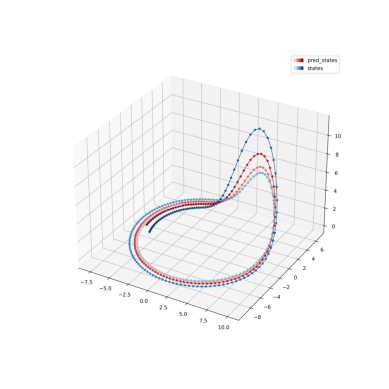

In [39]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/home/ma-user/work/Rossler/outputs_rossler_transformer/2025-06-15/19-51-45/visual/result_states0.png") 
plt.imshow(img)
plt.axis('off')
plt.show()